## Imports

In [96]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.base import clone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skrebate import ReliefF
import joblib

## Parameters

In [118]:
SEED = 42
num_features = 4

# --- Carregar dataset Iris ---
def load_data_set():
    data = load_iris()
    X = data.data
    y = data.target
    return X, y

def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Modelo salvo em {filename}")

def load_model(filename):
    model = joblib.load(filename)
    print(f"Modelo carregado de {filename}")
    return model


X_iris, y_iris = load_data_set()

## Ex 1

In [ ]:
#EX1
#EX1.1 ##################################
#EX1.1.1
#Usar critério 70/30 
def create_split_train_test(X, y, test_size=0.30, random_state=SEED):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test

#Usar critério 40/30/30
def create_split_tvt(X, y, val_size=0.30, test_size=0.30, random_state=SEED):
    # Primeiro separa o conjunto de teste
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Proporção relativa da validação dentro de X_temp (treino + validação)
    val_relative_size = val_size / (1.0 - test_size)

    # Depois separa treino e validação, estratificando por y_temp (não por y)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative_size, random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

#EX1.1.2
def create_split_kfold(X, y, n_splits=5, random_state=None, shuffle=False):

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    folds = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        folds.append((fold, X_train, X_test, y_train, y_test))

    return folds

#EX 1.2 ##################################
#EX 1.2.1
def calcular_matriz_confusao(y_true, y_pred):
    #Retorna a matriz de confusão.
    return confusion_matrix(y_true, y_pred)

def mean_std_confusion_matrix(list_of_cms):
    arr = np.stack(list_of_cms, axis=0)  # shape (n_folds, n_classes, n_classes)
    mean_cm = np.mean(arr, axis=0)
    std_cm  = np.std(arr, axis=0, ddof=0)
    return mean_cm, std_cm

#EX1.2.2
def recall(y_true, y_pred, average='macro'):
    #Calcula o Recall.
    #O parâmetro 'average' pode ser: 'binary', 'micro', 'macro', 'weighted'.
    return recall_score(y_true, y_pred, average=average, zero_division=0)

#EX1.2.3
def precision(y_true, y_pred, average='macro'):
    #Calcula a Precision.
    return precision_score(y_true, y_pred, average=average, zero_division=0)

#EX1.2.4
def f1(y_true, y_pred, average='macro'):
    #Calcula o F1-score.
    return f1_score(y_true, y_pred, average=average, zero_division=0)

def metrics_to_dataframe(y_true, y_pred, label=""):
    """
    y_true e y_pred podem ser:
      - arrays únicos -> retorna métricas normais
      - listas de arrays (K-Fold) -> retorna médias e std
    """
    is_kfold = isinstance(y_true, list)

    if not is_kfold:
        # Caso normal
        cm = calcular_matriz_confusao(y_true, y_pred)
        recall_val = recall(y_true, y_pred)
        precision_val = precision(y_true, y_pred)
        f1_val = f1(y_true, y_pred)

        df = pd.DataFrame({
            "Label": [label],
            "Recall": [recall_val],
            "Precision": [precision_val],
            "F1-Score": [f1_val],
            "ConfusionMatrix": [cm]
        })
    else:
        recalls, precisions, f1s, cms = [], [], [], []
        for yt, yp in zip(y_true, y_pred):
            recalls.append(recall(yt, yp))
            precisions.append(precision(yt, yp))
            f1s.append(f1(yt, yp))
            cms.append(calcular_matriz_confusao(yt, yp))

        cms_mean, cms_std = mean_std_confusion_matrix(cms)

        df = pd.DataFrame({
            "Label": [label],
            "Recall_Mean": [np.mean(recalls)],
            "Recall_Std": [np.std(recalls)],
            "Precision_Mean": [np.mean(precisions)],
            "Precision_Std": [np.std(precisions)],
            "F1_Mean": [np.mean(f1s)],
            "F1_Std": [np.std(f1s)],
            "ConfusionMatrices_mean": [cms_mean],
            "ConfusionMatrices_std": [cms_std]
        })

    return df

def print_metrics(y_true, y_pred, label="Metric Results", printing = True):
    """
    y_true e y_pred podem ser:
      - arrays únicos
      - listas de arrays (K-Fold)
    """
    is_kfold = isinstance(y_true, list)

    if not is_kfold:
        cm = calcular_matriz_confusao(y_true, y_pred)
        rec = recall(y_true, y_pred)
        prec = precision(y_true, y_pred)
        f1s = f1(y_true, y_pred)

        if printing:
            print(f"\n===== {label} =====")
            print("Confusion Matrix:")
            print(cm)
            print(f"Recall:    {rec:.4f}")
            print(f"Precision: {prec:.4f}")
            print(f"F1-Score:  {f1s:.4f}")
            print("=========================")

        return {"confusion_matrix": cm, "recall": rec, "precision": prec, "f1-score": f1s}

    else:
        recalls, precisions, f1s, cms = [], [], [], []
        for yt, yp in zip(y_true, y_pred):
            recalls.append(recall(yt, yp))
            precisions.append(precision(yt, yp))
            f1s.append(f1(yt, yp))
            cms.append(calcular_matriz_confusao(yt, yp))

        if printing:
            print(f"\n===== {label} - K-Fold results =====")
            print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
            print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
            print(f"F1-Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
            print("(Confusion matrices individuais guardadas no array.)")
            print("=========================")

        return {"confusion_matrices": cms, 
                "recall_mean": np.mean(recalls), "recall_std": np.std(recalls),
                "precision_mean": np.mean(precisions), "precision_std": np.std(precisions),
                "f1_mean": np.mean(f1s), "f1_std": np.std(f1s)}


## EX 2.1

In [99]:
# Função para o classificador Random
def classifier_random(X_train, y_train, X_test, y_test, label ="", printing = True):
    clf = DummyClassifier(strategy='uniform', random_state=SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
    metrics = print_metrics(y_test, y_pred, label=label, printing=printing)

    return metrics, y_pred

#Função para o classificador OneR
def classifier_oneR(X_train, y_train, X_test, y_test, max_depth=1, label = "", printing=True):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
    metrics = print_metrics(y_test, y_pred, label=label, printing=printing)

    return metrics, y_pred

#Função para o classificador kNN
def classifier_kNN(X_train, y_train, X_test, y_test, k, label = "", printing=True, filename=None):
    clf = KNeighborsClassifier(k)
    clf.fit(X_train, y_train)
    if X_test is not None:
        y_pred = clf.predict(X_test)

        # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
        metrics = print_metrics(y_test, y_pred, label=label, printing=printing)
        return metrics, y_pred
    else:
        save_model(clf, filename)

    

###########################################
################ MODELOS ##################
###########################################

def evaluate_with_kfold(X, y, classifier, rkf, label="KFOLD", printing=True):
    y_preds, y_trues = [], []

    for train_idx, test_idx in rkf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = clone(classifier)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_trues.append(y_test)
        y_preds.append(y_pred)

    # metrics_df = metrics_to_dataframe(y_trues, y_preds, label=label)
    metrics = print_metrics(y_trues, y_preds, label=label, printing=printing)
    return metrics

def random_baseline_kfold(X, y, rkf):
    clf = DummyClassifier(strategy='uniform', random_state=SEED)
    return evaluate_with_kfold(X, y, clf, rkf, label="RANDOM Baseline - KFOLD")

def oneR_baseline_kfold(X, y, rkf):
    clf = DecisionTreeClassifier(max_depth=1, random_state=SEED)
    return evaluate_with_kfold(X, y, clf, rkf, label="ONE R Baseline - KFOLD")

def random_baseline(X, y):
    # TRAIN ONLY:
    metrics_to, _ = classifier_random(X, y, X, y, label="RANDOM Baseline - TRAIN ONLY")

    # Train, test sets:
    X_train_70, X_test_70, y_train_30, y_test_30 = create_split_train_test(X, y, test_size=0.3, random_state=SEED)
    metrics_tt, _ = classifier_random(X_train_70, y_train_30, X_test_70, y_test_30, label="RANDOM Baseline - Train Test")

    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=SEED)
    metrics_cv = random_baseline_kfold(X, y, rkf)

    return metrics_to, metrics_tt, metrics_cv

def oneR_baseline(X, y):
        # TRAIN ONLY:
    metrics_to, _ = classifier_oneR(X, y, X, y, label="ONE R TRAIN ONLY")

    # Train, test sets:
    X_train_70, X_test_70, y_train_30, y_test_30 = create_split_train_test(X, y, test_size=0.3, random_state=SEED)
    metrics_tt, _ = classifier_oneR(X_train_70, y_train_30, X_test_70, y_test_30, label="ONE R Train Test")

    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=SEED)
    metrics_cv = oneR_baseline_kfold(X, y, rkf)

    return metrics_to, metrics_tt, metrics_cv

def ex_2_1(X, y):

    # RANDOM BASELINE
    ran_to, ran_tt, ran_cv = random_baseline(X, y)

    # ONER BASELIDE
    one_to, one_tt, one_cv = oneR_baseline(X, y)

    return

ex_2_1(X_iris, y_iris)


===== RANDOM Baseline - TRAIN ONLY =====
Confusion Matrix:
[[16 19 15]
 [20 19 11]
 [16 14 20]]
Recall:    0.3667
Precision: 0.3693
F1-Score:  0.3676

===== RANDOM Baseline - Train Test =====
Confusion Matrix:
[[6 3 6]
 [3 7 5]
 [7 5 3]]
Recall:    0.3556
Precision: 0.3520
F1-Score:  0.3536

===== RANDOM Baseline - KFOLD - K-Fold results =====
Recall:    0.3333 ± 0.0000
Precision: 0.3278 ± 0.0000
F1-Score:  0.3286 ± 0.0000
(Confusion matrices individuais guardadas no array.)

===== ONE R TRAIN ONLY =====
Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0 50  0]]
Recall:    0.6667
Precision: 0.5000
F1-Score:  0.5556

===== ONE R Train Test =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0 15  0]]
Recall:    0.6667
Precision: 0.5000
F1-Score:  0.5556

===== ONE R Baseline - KFOLD - K-Fold results =====
Recall:    0.6667 ± 0.0000
Precision: 0.5000 ± 0.0000
F1-Score:  0.5556 ± 0.0000
(Confusion matrices individuais guardadas no array.)


## EX 2.2.1

In [17]:


## EX2.2.1 ################################
def ex_2_2_1(X_iris, y_iris):

    k = 1
    clf_k = KNeighborsClassifier(n_neighbors = k)

    # TT
    clf_k.fit(X_iris, y_iris)
    y_pre_trainonly = clf_k.predict(X_iris)
    print_metrics(y_iris, y_pre_trainonly, "KNN FOR TRAIN ONLY")

    # TT 70-30
    X_train_70, X_test_30, y_train_70, y_test_30 = create_split_train_test(X_iris, y_iris, test_size=0.3, random_state=SEED)
    clf_k.fit(X_train_70, y_train_70)
    y_pre_tt_70_30 = clf_k.predict(X_test_30)
    print_metrics(y_test_30, y_pre_tt_70_30, "KNN FOR TRAIN TEST 70-30")

    # KFolds
    rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats=10, random_state=SEED)
    clf_for_kfolds = KNeighborsClassifier(n_neighbors=k)
    evaluate_with_kfold(X_iris, y_iris, clf_for_kfolds, rkf, label="KNN KFOLDS")

    # print_metrics(cms, precisions, recalls, f1s)

ex_2_2_1(X_iris, y_iris)


===== KNN FOR TRAIN ONLY =====
Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Recall:    1.0000
Precision: 1.0000
F1-Score:  1.0000

===== KNN FOR TRAIN TEST 70-30 =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
Recall:    0.9778
Precision: 0.9792
F1-Score:  0.9778

===== KNN KFOLDS - K-Fold results =====
Recall:    0.9587 ± 0.0460
Precision: 0.9648 ± 0.0407
F1-Score:  0.9581 ± 0.0467
(Confusion matrices individuais guardadas no array.)


## EX 2.2.2

======================================== TO - Different k nearest
======================================== TVT - Different k nearest
======================================== 10x10CV - Different k nearest


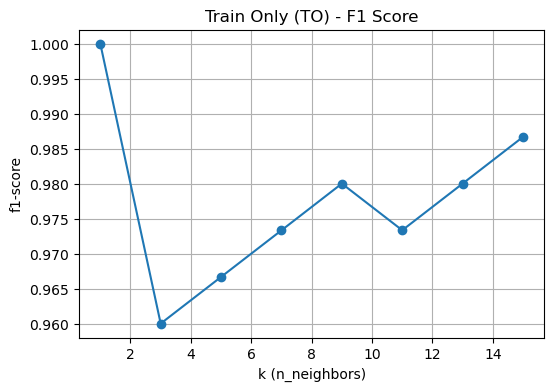

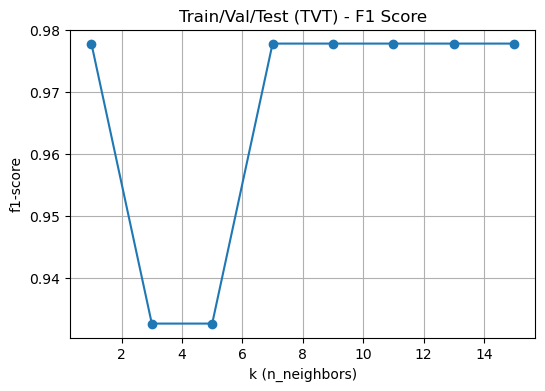

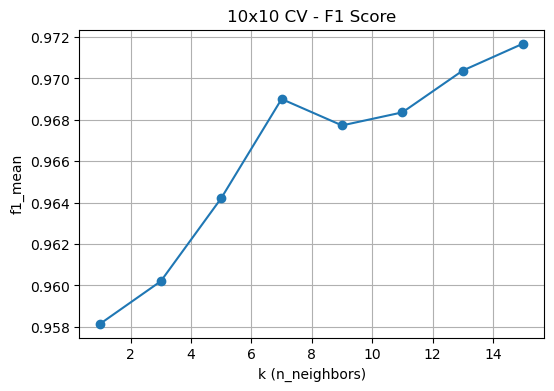

In [119]:
## EX2.2.2 ################################

PRINTING = False

def plot_metrics(metrics_list, metric_name='f1-score', title='Metric Plot'):
    ks = [m['k'] for m in metrics_list]
    values = [m[metric_name] for m in metrics_list]

    plt.figure(figsize=(6,4))
    plt.plot(ks, values, marker='o')
    plt.xlabel("k (n_neighbors)")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)
    plt.show()

# ⚠️ Pôr a guardar em CSV
def ex_2_to(X_iris, y_iris, min_range=1, max_range=15, step=2, printing = True):
    metrics_list = []

    for k in range(min_range, max_range + 1, step):
        clf_k = KNeighborsClassifier(n_neighbors=k)
        clf_k.fit(X_iris, y_iris)
        y_pred = clf_k.predict(X_iris)
        metrics = print_metrics(y_iris, y_pred, f"Train only - k={k}", printing=printing)
        metrics['k'] = k
        metrics_list.append(metrics)

    return metrics_list

def ex_2_tvt(X_iris, y_iris, min_range = 1, max_range = 15, step = 2, printing=True):
    metrics_list = []

    for i in range(min_range, max_range + 1, step):
        k = i
        clf_k = KNeighborsClassifier(n_neighbors = k)

        X_train_40, X_temp, y_train_40, y_temp = create_split_train_test(X_iris, y_iris, test_size=0.6, random_state=SEED)
        X_test_30, X_val_30, y_test_30, y_val_30 = create_split_train_test(X_temp, y_temp, test_size=0.5, random_state=SEED)
        
        clf_k.fit(X_train_40, y_train_40)
        y_pre_tt_40_30_30 = clf_k.predict(X_val_30)

        metrics = print_metrics(y_val_30, y_pre_tt_40_30_30, f"TT 40-30-30 - {k}", printing=printing)
        metrics['k'] = k
        metrics_list.append(metrics)
    
    return metrics_list

def ex_2_cv(X_iris, y_iris, min_range = 1, max_range = 15, step = 2, printing=True):
    metrics_list = []

    for i in range(min_range, max_range + 1, step):
        k = i
        rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats=10, random_state=SEED)

        clf_for_kfolds = KNeighborsClassifier(n_neighbors=k)
        metrics = evaluate_with_kfold(X_iris, y_iris, clf_for_kfolds, rkf, label="KNN KFOLDS", printing=printing)

        metrics['k'] = k
        metrics_list.append(metrics)

    return metrics_list

def ex_2_2_2(X_iris, y_iris, min_range = 1, max_range = 15, step = 2, printing=True):
    print("=" * 40, "TO - Different k nearest")
    to_metrics = ex_2_to(X_iris, y_iris, min_range = min_range, max_range = max_range, step = step, printing=PRINTING)

    print("=" * 40, "TVT - Different k nearest")
    tvt_metrics = ex_2_tvt(X_iris, y_iris, min_range = min_range, max_range = max_range, step = step, printing=PRINTING)

    print("=" * 40, "10x10CV - Different k nearest")
    cv_metrics = ex_2_cv(X_iris, y_iris, min_range = min_range, max_range = max_range, step = step, printing=PRINTING)

    plot_metrics(to_metrics, metric_name='f1-score', title='Train Only (TO) - F1 Score')
    plot_metrics(tvt_metrics, metric_name='f1-score', title='Train/Val/Test (TVT) - F1 Score')
    plot_metrics(cv_metrics, metric_name='f1_mean', title='10x10 CV - F1 Score')

    return to_metrics, tvt_metrics, cv_metrics

to_metrics, tvt_metrics, cv_metrics = ex_2_2_2(X_iris, y_iris)

### Values in Tables

In [ ]:
def metrics_summary_all(to_metrics, tvt_metrics, cv_metrics, min_k=1, max_k=15, step=2):
    """
    Retorna 3 DataFrames, um para cada tipo de experimento (TO, TVT, CV),
    com colunas: k, recall, precision, f1
    """
    ks = list(range(min_k, max_k+1, step))
    
    def summary_df(metrics_list, ks):
        recall_vals, precision_vals, f1_vals = [], [], []
        for m in metrics_list:
            if 'recall' in m:
                recall_vals.append(m['recall'])
                precision_vals.append(m['precision'])
                f1_vals.append(m['f1-score'])
            else:
                recall_vals.append(m['recall_mean'])
                precision_vals.append(m['precision_mean'])
                f1_vals.append(m['f1_mean'])
        return pd.DataFrame({
            'k': ks,
            'recall': recall_vals,
            'precision': precision_vals,
            'f1': f1_vals
        })
    
    df_to = summary_df(to_metrics, ks)
    df_tvt = summary_df(tvt_metrics, ks)
    df_cv = summary_df(cv_metrics, ks)
    
    return df_to, df_tvt, df_cv

# Uso:
df_to, df_tvt, df_cv = metrics_summary_all(to_metrics, tvt_metrics, cv_metrics, min_k=1, max_k=15, step=2)

print("=== Train Only (TO) ===")
display(df_to)

print("=== Train/Val/Test (TVT) ===")
display(df_tvt)

print("=== 10x10 CV ===")
display(df_cv)


=== Train Only (TO) ===


,k,recall,precision,f1
0,1,1.000000,1.000000,1.000000
1,3,0.960000,0.960000,0.960000
2,5,0.966667,0.966787,0.966663
3,7,0.973333,0.973825,0.973323
4,9,0.980000,0.980125,0.979998
5,11,0.973333,0.973333,0.973333
6,13,0.980000,0.980125,0.979998
7,15,0.986667,0.986667,0.986667


=== Train/Val/Test (TVT) ===


,k,recall,precision,f1
0,1,0.911111,0.915535,0.910714
1,3,0.911111,0.915535,0.910714
2,5,0.911111,0.915535,0.910714
3,7,0.888889,0.898148,0.887767
4,9,0.866667,0.881978,0.864253
5,11,0.866667,0.881978,0.864253
6,13,0.888889,0.916667,0.885714
7,15,0.866667,0.904762,0.861111


=== 10x10 CV ===


,k,recall,precision,f1
0,1,0.958667,0.964802,0.958148
1,3,0.961333,0.966921,0.960897
2,5,0.968000,0.973143,0.967591
3,7,0.968000,0.972540,0.967660
4,9,0.968000,0.972167,0.967731
5,11,0.974667,0.978167,0.974438
6,13,0.975333,0.978944,0.975098
7,15,0.973333,0.976833,0.973104


## EX 2.3.1 - TVT
### Best features

Score:
[3 2 0 1]

===== KNN - k = 1 - feature ranking: [3] =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]
Recall:    0.9556
Precision: 0.9608
F1-Score:  0.9554

===== KNN - k = 1 - feature ranking: [3 2] =====
Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  1 14]]
Recall:    0.9556
Precision: 0.9556
F1-Score:  0.9556

===== KNN - k = 1 - feature ranking: [3 2 0] =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
Recall:    0.9778
Precision: 0.9792
F1-Score:  0.9778

===== KNN - k = 1 - feature ranking: [3 2 0 1] =====
Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  1 14]]
Recall:    0.9556
Precision: 0.9556
F1-Score:  0.9556


,n_features,recall,precision,f1
0,1,0.955556,0.960784,0.955357
1,2,0.955556,0.955556,0.955556
2,3,0.977778,0.979167,0.977753
3,4,0.955556,0.955556,0.955556


TOP 3 features
BEST FEATURES [3 2 0]


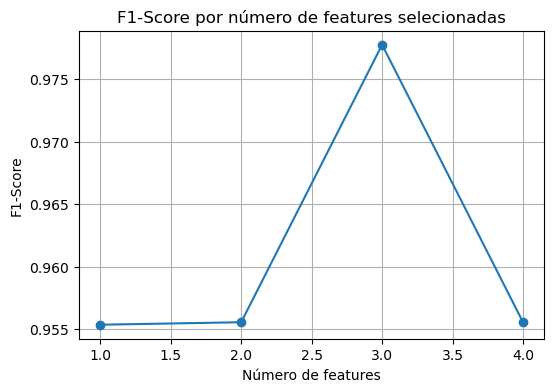

In [120]:
def metrics_summary_features(metrics_list):
    n_features = [m['n_features'] for m in metrics_list]
    recall = []
    precision = []
    f1 = []

    for m in metrics_list:
        recall.append(m['recall'])
        precision.append(m['precision'])
        f1.append(m['f1-score'])

    return pd.DataFrame({
        'n_features': n_features,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })

def compute_feature_ranking(X, y):
    relief = ReliefF(n_neighbors=20)
    relief.fit(X, y)
    scores = relief.feature_importances_

    return np.argsort(scores)[::-1]     # ordem decrescente

def bestFeatures(X_train, y_train, X_val, y_val):
    scores = compute_feature_ranking(X_train, y_train)
    print("Score:")
    print(scores)

    k_base = 1

    metrics_list = []

    for i in range(len(scores)):
        X_train_i = X_train[:, scores[:i+1]]
        X_val_i = X_val[:, scores[:i+1]]
        # def classifier_kNN(X_train, y_train, X_test, y_test, k, label = "", printing=True):
        metrics, _ = classifier_kNN(X_train_i, y_train, X_val_i, y_val, k_base, f"KNN - k = 1 - feature ranking: {scores[:i+1]}", printing=True)
        
        metrics['n_features'] = i+1
        metrics_list.append(metrics)
    
    df_feat = metrics_summary_features(metrics_list)
    display(df_feat)

    best_idx = df_feat['f1'].idxmax()
    best_n = df_feat.loc[best_idx, 'n_features']
    best_features = scores[:best_n]

    print(f"TOP {len(best_features)} features")
    print("BEST FEATURES", best_features)

    # Plot do F1
    plt.figure(figsize=(6,4))
    plt.plot(df_feat['n_features'], df_feat['f1'], marker='o')
    plt.xlabel("Número de features")
    plt.ylabel("F1-Score")
    plt.title("F1-Score por número de features selecionadas")
    plt.grid(True)
    plt.show()
    
    return best_features


X_train, X_val, X_test, y_train, y_val, y_test = create_split_tvt(X_iris, y_iris)

best_features = bestFeatures(X_train, y_train, X_val, y_val)

### Best k

In [88]:
def best_k_tvt(X_train, y_train, X_val, y_val, min_range=1, max_range=15, step=2, printing = True):
    f1_list = []

    for k in range(min_range, max_range + 1, step):
        tuple = classifier_kNN(X_train, y_train, X_val, y_val, k, f"KNN - best K : {k}", printing=False)
        f1 = {'f1-score': tuple[0]['f1-score']}
        f1['k'] = k
        f1_list.append(f1)

    return f1_list

def best_parameter_values(X_train, y_train, X_val, y_val, best_features, min_range = 1, max_range = 15, step = 2):
    X_train = X_train[:, best_features]
    X_val = X_val[:, best_features]
    
    f1_list = best_k_tvt(X_train, y_train, X_val, y_val)

    df = pd.DataFrame(f1_list)
    display(df)

    # k com maior f1-score
    best_idx = df['f1-score'].idxmax()
    best_k = df.loc[best_idx, 'k']
    
    print(f"Melhor k com maior F1-score: {best_k}")
    return best_k

best_k = best_parameter_values(X_train, y_train, X_val, y_val, best_features)

,f1-score,k
0,0.977753,1
1,0.977753,3
2,0.977753,5
3,1.000000,7
4,0.977753,9
5,0.977753,11
6,0.977753,13
7,0.977753,15


Melhor k com maior F1-score: 7


### Train with Tr+V -> Get T

"Estimation of exa..."
1.4

In [91]:

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

metrics, _ = classifier_kNN(X_train_val, y_train_val, X_test, y_test, best_k, f"KNN - features: {best_features} - k={best_k}", printing=True)



===== KNN - features: [3 2 0] - k=7 =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]
Recall:    0.9556
Precision: 0.9608
F1-Score:  0.9554


### Deployment

In [101]:
filename = "./models/ex_2_3_1_knn_tvt.pkl"
label = f"KNN Deploy | features: {best_features} - k={best_k}"

classifier_kNN(X_iris, y_iris, None, None, best_k, label=label, filename = filename)

Modelo salvo em ./models/ex_2_3_1_knn_tvt.pkl


## EX 2.3.1 - CV

In [ ]:
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=SEED)
print(rkf.split(X_iris, y_iris))

folds = []

def compute_feature_ranking(X, y):
    relief = ReliefF(n_neighbors=20)
    relief.fit(X, y)
    scores = relief.feature_importances_

    return np.argsort(scores)[::-1]     # ordem decrescente

def parameter_selection_per_fold():
    

def ex_2_3_1_cv(X, y):

    for train_idx, test_idx in rkf.split(X, y):
        # train (90%) + test (10%)
        X_train_orig, X_test = X[train_idx], X[test_idx]
        y_train_orig, y_test = y[train_idx], y[test_idx]

        # train (90% * 0.9) + validation (90% * 0.1)
        # 80 + 10 + 10
        X_train, X_val, y_train, y_val = create_split_train_test(X_train_orig, y_train_orig, test_size=0.1)

        dic = {"X_train_orig": X_train_orig, 
            "y_train_orig": y_train_orig,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "X_val": X_val,
            "X_val": y_val}
        
        folds.append(dic)
    
    


<generator object _RepeatedSplits.split at 0x000001B4C62E3350>
[  0   1   2   3   4   5   6   9  10  11  12  13  14  15  16  17  18  19
  20  22  23  24  25  26  27  28  29  30  32  33  34  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 117 118
 119 120 121 122 123 124 125 127 128 129 130 131 133 135 136 137 138 139
 140 141 143 144 145 146 147 148 149] [  7   8  21  31  35  50  66  83  89  99 116 126 132 134 142]
[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  58  59
  60  61  62  63  64  66  67  68  69  70  72  73  74  75  76  77  78  79
  80  82  83  84  86  87  88  89  